# **CAPSTONE PROJECT MODULE 2**

`by Giovano Aditya Graha`

---
---

## **DATA UNDERSTANDING**

### a. Context

A company engaged in the export-import (shipping) of electronic equipments wants to know about the overlapping salaries of its employees and how the company retains the employees so that employees receive appropriate wages.

There is a database showing the details of each employee. From the database, the company wants to gain insight so that later the company can implement a reward and punishment strategy that is right on target to its employees for the satisfaction of every employee and providing the best performance.

### b. Database Information

$$Human\ Resources\ Database$$

[Download database](https://drive.google.com/drive/folders/1G9Q2sohMFVes7NCHaUHcuAAjlOybBYJG?usp=sharing)

HR database has 7 tables, namely:
- Countries : Describes information about country data based on the location of the region (ID and Region ID).
- Departments: Describes information about the details of each department in the HR database.
- Employees : Describes information about each employee from name, contact (email, phone), date of joining, job title and position, salary amount ($), boss ID, and department ID.
- Job History: Describes information on the start and end dates of certain employees who have been transferred or given promotions.
- Jobs : Describes detailed salary ranges (MIN and MAX) of each Job Title.
- Locations: Describes office location data in various countries in the world.
- Regions : Describes information about the continent of each office location.

Each table contained in the database can be connected, either directly or indirectly, so that any information from this database will be interrelated. Details of the relationships between tables can be seen in the Entity Relationship Diagram as follows,

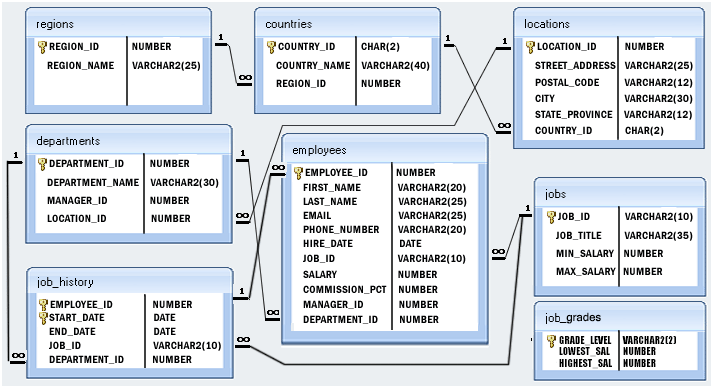

---

## **LIBRARIES**

In [143]:
# SQL Connector
import mysql.connector
import sqlalchemy as alc
from sqlalchemy import create_engine

# Data Processing
import numpy as np
import pandas as pd
import scipy.stats as stats

# Statistics
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import kruskal

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Ignore Warning
import warnings
warnings.filterwarnings('ignore')

---

## **DATABASE**

This section is the first step to start the data analysis process. The first is to make a connection to the database where as previously explained, the database to be used is `HR Database`. By making this connection, we can access all the tables in the database.

In [144]:
# ----------------------------- SQL ENGINE -----------------------------
mydb = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    passwd = '_',
    database = 'HR'
)

engine = create_engine('mysql+mysqlconnector://root:_@localhost/HR')
# -----------------------------------------------------------------------

To simplify this case, we are ordered to join some features from multiple tables. The following features are considered as the most important variables from `employees`, `jobs`, `departments`, `locations`, `countries`, and `regions` tables:

**`employees`**
- EMPLOYEE_ID 
- FIRST_NAME 
- LAST_NAME 
- SALARY
- HIRE_DATE
- JOB_ID            (`*`)
- DEPARTMENT_ID     (`*`)
- MANAGER_ID

**`jobs`**
- JOB_ID
- JOB_TITLE 
- MIN_SALARY 
- MAX_SALARY

**`departments`**
- DEPARTMENT_ID
- DEPARTMENT_NAME 
- LOCATION_ID       (`*`)

**`locations`**
- LOCATION_ID       (`*`)
- STREET_ADDRESS 
- CITY 
- COUNTRY_ID        (`*`)

**`countries`**
- COUNTRY_ID        (`*`)
- COUNTRY_NAME 
- REGION_ID         (`*`)

**`regions`**
- REGION_ID         (`*`)
- REGION_NAME

(`*`) : *Join on Key(s) Variable*

===========================================================================

Before going any further into the query, `update` and `set` are required for the database in SQL to make it easier for users to understand the contents of the database.

1.
update locations
set country_id = 'UK'
where location_id = 2500;

> BEFORE 'UK' is 'OX'

2.
update locations
set country_id = 'MX'
where location_id = 3200;

> BEFORE 'MX' is ' " '

3.
update employees
set department_id = 80
where EMPLOYEE_ID = 178;

> BEFORE '80' is '0'

===========================================================================

In [145]:
query = '''
select e.EMPLOYEE_ID as ID, CONCAT(e.FIRST_NAME,' ',e.LAST_NAME) as Name, d.department_name as Department, j.JOB_TITLE as Job, l.STREET_ADDRESS as Address, l.city as City, c.country_name as Country, r.region_name as Region,
j.MIN_SALARY as Job_Min_Salary, e.SALARY as Salary, j.MAX_SALARY as Job_Max_Salary, e.HIRE_DATE as Hire_Date, e.MANAGER_ID as Manager
from employees e
join jobs j
on e.job_id = j.job_id
join departments d
on e.department_id = d.department_id
join locations l
on d.location_id = l.location_id
join countries c
on l.country_id = c.country_id
join regions r
on c.region_id = r.region_id;
'''
df = pd.read_sql(query, engine)

---

## **FUNCTIONS**

The following are functions that will make it easier for us to perform data analysis:

In [146]:
# -----------------------------------------------------------------------
# Salary Classification

job_grade_list = []
def job_grade(x):
    for i in range(len(df[x])):
        if 'President' in df[x][i] and 'Vice' not in df[x][i]:
            job_grade_list.append('A')
        elif 'Vice President' in df[x][i]:
            job_grade_list.append('B')
        elif 'Manager' in df[x][i]:
            job_grade_list.append('C')
        elif 'Clerk' in df[x][i]:
            job_grade_list.append('E')
        else:
            job_grade_list.append('D')
    return job_grade_list

# -----------------------------------------------------------------------
# Grade Class Classification - CONCLUSION

grade_class_list = []
def grade_class(x):
    for i in range(len(df[x])):
        if df['Grade'][i] == 'B' or df['Grade'][i] == 'A':
            grade_class_list.append('Management')
        else:
            if df['Salary'][i] < df[df[x]==df[x][i]]['Salary'].median():
                grade_class_list.append('Junior')
            elif df['Salary'][i] == df[df[x]==df[x][i]]['Salary'].median():
                grade_class_list.append('Middle')
            else:
                grade_class_list.append('Senior')
    return grade_class_list

# -----------------------------------------------------------------------
# Outlier(s)

def outlier(a):
    # q
    q1 = a.describe()['25%']
    q2 = a.describe()['50%']
    q3 = a.describe()['75%']

    # IQR
    iqr = q3 - q1

    # Outliers
    min_IQR = q1 - 1.5 * iqr
    max_IQR = q3 + 1.5 * iqr

    low_out = []
    high_out = []

    for i in a:
        if (i < min_IQR):
            low_out.append(i)
        if (i > max_IQR):
            high_out.append(i)

    # Boundaries
    print('Lower Boundary \t: ', min_IQR)
    print('Upper Boundary \t: ', max_IQR)
    print()

    # Count of Outlier(s)
    print('Count of Low Outlier(s) \t: ', len(low_out))
    print('Count of High Outlier(s) \t: ', len(high_out))
    print()

    # Outliers List
    print('Low Outlier(s) List \t: ', low_out)
    print('High Outlier(s) List \t: ', high_out)

# -----------------------------------------------------------------------
# Central Tendency

def plot_central_tendency(col, kind='hist'):
    mean_score = df[col].mean()
    median_score = df[col].median()

    sns.displot(df[col], kind=kind)
    plt.axvline(mean_score, ls='--', color='green', label='mean')
    plt.axvline(median_score, ls='--', color='orange', label='median')
    plt.legend()
    plt.show()

# -----------------------------------------------------------------------
# Normality Testing - DAP

def normal(variabel):
    stat, pvalue = stats.normaltest(variabel)

    print(f'''
    H0 : {variabel.name} is a normal distribution.
    Ha : {variabel.name} is not a normal distribution.
    ''')

    if pvalue <= 0.05:
        print(f'pvalue {variabel.name} = {pvalue:.10f}. Reject Ho. We do not assume {variabel.name} is a normal distribution.')
    else:
        print(f'pvalue {variabel.name} = {pvalue:.10f}. Failed to reject Ho. We assume {variabel.name} is a normal distribution.')
        
# -----------------------------------------------------------------------

---

## **DATA PREPROCESSING - DATA MANIPULATION**

**Besides of the features from the `querry` above, we have to create following additional feature(s) to help us solve the problem:**
1. **Grade** : derived from the classification of Job Title.
     -    **A** : Classified as a President. *Director*
     -    **B** : Classified as a Vice President. *Upper Level Management* 
     -    **C**: Classified as a Manager. *First Level Management*
     -    **D**: Classified as a Staff. *Skilled Labor*
     -    **E** : Classified as a Clerk. *Semi-Skilled Labor*
     
     From this we can conclude that Staff reports to Manager, Manager reports to either Vice President or direct to President. *MANAGER_ID* feature will support this assumption.

2. **Grade_Ordinal** : derived from the Grade classification to describe Job Title ordinary.
     -    **1** : for E
     -    **2** : for D
     -    **3** : for C
     -    **4** : for B
     -    **5** : for A

     To classified the Grades

In [147]:
# Additional Feature(s) according to point above.

# Grade
df['Grade'] = job_grade('Job')

# Grade_Ordinal
df['Grade_Ordinal'] = [1 if x=='E' else (2 if x=='D' else (3 if x=='C' else (4 if x=='B' else (5 if x=='A' else 0)))) for x in df['Grade']]

## RunOnce

In [148]:
df.head()

,ID,Name,Department,Job,Address,City,Country,Region,Job_Min_Salary,Salary,Job_Max_Salary,Hire_Date,Manager,Grade,Grade_Ordinal
0,200.0,Jennifer Whalen,Administration,Administration Assistant,2004 Charade Rd,Seattle,United States of America,Americas\r,3000.0,4400.0,6000.0,1987-09-25,101.0,D,2
1,201.0,Michael Hartstein,Marketing,Marketing Manager,147 Spadina Ave,Toronto,Canada,Americas\r,9000.0,13000.0,15000.0,1987-09-26,100.0,C,3
2,202.0,Pat Fay,Marketing,Marketing Representative,147 Spadina Ave,Toronto,Canada,Americas\r,4000.0,6000.0,9000.0,1987-09-27,201.0,D,2
3,114.0,Den Raphaely,Purchasing,Purchasing Manager,2004 Charade Rd,Seattle,United States of America,Americas\r,8000.0,11000.0,15000.0,1987-07-01,100.0,C,3
4,115.0,Alexander Khoo,Purchasing,Purchasing Clerk,2004 Charade Rd,Seattle,United States of America,Americas\r,2500.0,3100.0,5500.0,1987-07-02,114.0,E,1


### 1. Data Anomalies

In [149]:
# General Information of the Data
df.info()

# Shows number of rows and columns along with the data type on each columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              107 non-null    float64
 1   Name            107 non-null    object 
 2   Department      107 non-null    object 
 3   Job             107 non-null    object 
 4   Address         107 non-null    object 
 5   City            107 non-null    object 
 6   Country         107 non-null    object 
 7   Region          107 non-null    object 
 8   Job_Min_Salary  107 non-null    float64
 9   Salary          107 non-null    float64
 10  Job_Max_Salary  107 non-null    float64
 11  Hire_Date       107 non-null    object 
 12  Manager         107 non-null    float64
 13  Grade           107 non-null    object 
 14  Grade_Ordinal   107 non-null    int64  
dtypes: float64(5), int64(1), object(9)
memory usage: 12.7+ KB


In [150]:
# Duplicated Data Checking
df.duplicated().any()

# If FALSE means that there is no data (row) which has exactly same with others. Meanwhile TRUE, shows that the dupliacte data is exist.

False

In [151]:
# Missing Value Checking
df.isna().sum()

# to find out number of data which has NaN value on the dataframe.

ID                0
Name              0
Department        0
Job               0
Address           0
City              0
Country           0
Region            0
Job_Min_Salary    0
Salary            0
Job_Max_Salary    0
Hire_Date         0
Manager           0
Grade             0
Grade_Ordinal     0
dtype: int64

From `Cell 30` and `Cell 31` we may assume that the data is already clean.

### 2. Update Spesific Features


From the data frame that we have prepared above, there are still several features that are not in accordance with their potential. We had to update the data to properly align the function.

In [152]:
# Update Data Types
df['Hire_Date'] = pd.to_datetime(df['Hire_Date'])
df['ID'] = df['ID'].astype(int).astype(str)
df['Manager'] = df['Manager'].astype(int).astype(str)

In [153]:
# Remove "\r" on Region Column
df['Region'] = df['Region'].str.replace('\r','')

### 3. Cleaned Data General Info

Check some info to re-check the features that have been updated.

In [154]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, len(df),df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)])

df_cleaned_desc = pd.DataFrame(columns=['Columns', 'Data Type', 'Data Count', 'Missing Value', 
    'Missing Value Percentage', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
df_cleaned_desc

,Columns,Data Type,Data Count,Missing Value,Missing Value Percentage,Number of Unique,Unique Sample
0,ID,object,107,0,0.0,107,"[121, 118]"
1,Name,object,107,0,0.0,107,"[Allan McEwen, Nancy Greenberg]"
2,Department,object,107,0,0.0,11,"[Sales, Marketing]"
3,Job,object,107,0,0.0,19,"[Programmer, Stock Manager]"
4,Address,object,107,0,0.0,7,"[""Magdalen Centre, 2004 Charade Rd]"
5,City,object,107,0,0.0,7,"[OX9 9ZB, South San Francisco]"
6,Country,object,107,0,0.0,4,"[Canada, United Kingdom]"
7,Region,object,107,0,0.0,2,"[Europe, Americas]"
8,Job_Min_Salary,float64,107,0,0.0,14,"[2000.0, 6000.0]"
9,Salary,float64,107,0,0.0,57,"[3300.0, 10000.0]"


### 4. Reselect the Features

After the cleaned data type is appropriate, we will sort out which features we will actually use.

In [155]:
df['Hire_Date'].dt.to_period('Y').nunique()

1

If we look at the dataframe, the year in which every employee was recruited by the company was the same, namely in 1987. With the aim of our problem regarding the salary for each employee, this feature (`Hire_Date`) is less informative because all employees were hired in the same year so as to reduce the assumption of salary differences related to an increase in the UMR or an inflation event every year so that this variable can be considered for us to drop.

Another variable that can be considered for us to drop is `Manager` because we can conclude the function of this variable from the previous statement that an employee should report to his/her superiors.

In [156]:
df = df.drop(['Hire_Date','Manager'],axis=1)

In [157]:
df

,ID,Name,Department,Job,Address,City,Country,Region,Job_Min_Salary,Salary,Job_Max_Salary,Grade,Grade_Ordinal
0,200,Jennifer Whalen,Administration,Administration Assistant,2004 Charade Rd,Seattle,United States of America,Americas,3000.0,4400.0,6000.0,D,2
1,201,Michael Hartstein,Marketing,Marketing Manager,147 Spadina Ave,Toronto,Canada,Americas,9000.0,13000.0,15000.0,C,3
2,202,Pat Fay,Marketing,Marketing Representative,147 Spadina Ave,Toronto,Canada,Americas,4000.0,6000.0,9000.0,D,2
3,114,Den Raphaely,Purchasing,Purchasing Manager,2004 Charade Rd,Seattle,United States of America,Americas,8000.0,11000.0,15000.0,C,3
4,115,Alexander Khoo,Purchasing,Purchasing Clerk,2004 Charade Rd,Seattle,United States of America,Americas,2500.0,3100.0,5500.0,E,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,111,Ismael Sciarra,Finance,Accountant,2004 Charade Rd,Seattle,United States of America,Americas,4200.0,7700.0,9000.0,D,2
103,112,Jose Manuel Urman,Finance,Accountant,2004 Charade Rd,Seattle,United States of America,Americas,4200.0,7800.0,9000.0,D,2
104,113,Luis Popp,Finance,Accountant,2004 Charade Rd,Seattle,United States of America,Americas,4200.0,6900.0,9000.0,D,2
105,205,Shelley Higgins,Accounting,Accounting Manager,2004 Charade Rd,Seattle,United States of America,Americas,8200.0,12000.0,16000.0,C,3


---

## **STATISTICS**

### Salary

As our main goal, we need to know the detailed statistics for the Salary feature. Feature for this Salary is assumed in USD exchange rate ($)

#### - Distribution

The following is a `Histogram Displot` to illustrate the Salary distribution for each employee.

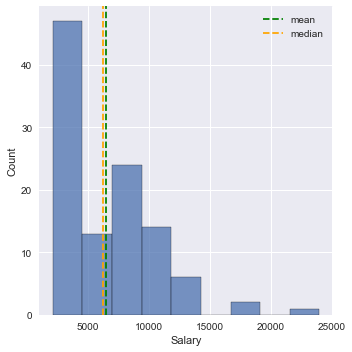

In [158]:
# Central Tendency - Mean and Median
plot_central_tendency('Salary')

From the visualization above, it can be concluded that the distribution of Salary for all employees is not a normal distribution, but a *Right-Skewed Distribution*.

$Median < Mean$

These assumptions can be strengthened by frequent hypothesis testing,

In [159]:
# by D’Agostino and Pearson’s Test
normal(df['Salary'])


    H0 : Salary is a normal distribution.
    Ha : Salary is not a normal distribution.
    
pvalue Salary = 0.0000000492. Reject Ho. We do not assume Salary is a normal distribution.


#### - Outlier(s)

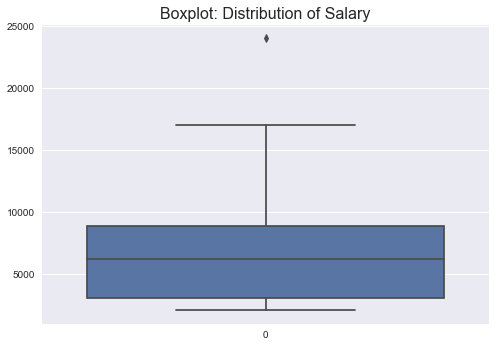

In [160]:
sns.boxplot(data = df['Salary'])
plt.title('Boxplot: Distribution of Salary', size=16)
plt.show()

In [161]:
outlier(df['Salary'])

Lower Boundary 	:  -5600.0
Upper Boundary 	:  17600.0

Count of Low Outlier(s) 	:  0
Count of High Outlier(s) 	:  1

Low Outlier(s) List 	:  []
High Outlier(s) List 	:  [24000.0]


In [162]:
# Salary Max
df[df['Salary']>17600]

,ID,Name,Department,Job,Address,City,Country,Region,Job_Min_Salary,Salary,Job_Max_Salary,Grade,Grade_Ordinal
96,100,Steven King,Executive,President,2004 Charade Rd,Seattle,United States of America,Americas,20000.0,24000.0,40000.0,A,5


If we describe it using *Pandas.describe()* or by looking at the selection data as above, it can be seen that the smallest Salary is $2100 and is in accordance with the previous Salary Distribution box plot visualization.

However, if we compare the definition of the lower limit with its IQR, the lower limit by definition is $-5600. This definition violates the assumption that Salary is something we should get instead of giving and even getting nothing ($0). This confirms the boxplot above and shows the skewness of the Salary distribution.

While the upper limit is in the range of $17600. Above this upper limit, it is considered an outlier value. The only outlier in this data is the Salary from the President Director i.e. $24000.

#### - Correlation

##### Linearity Checking

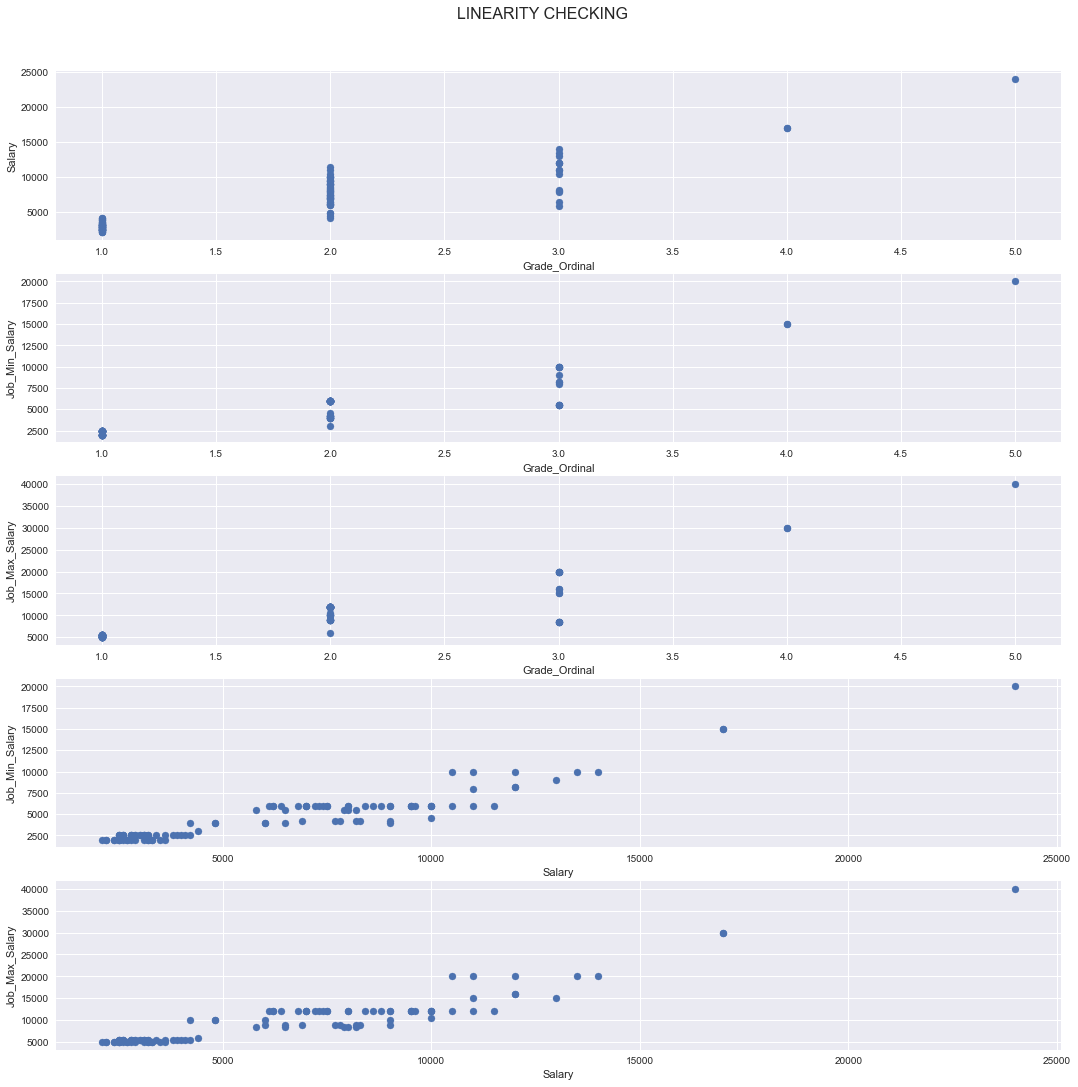

In [163]:
fig, ax = plt.subplots(5, figsize=(18, 18))
ax[0].scatter(x = df['Grade_Ordinal'], y = df['Salary'])
ax[0].set_xlabel("Grade_Ordinal")
ax[0].set_ylabel("Salary")

ax[1].scatter(x = df['Grade_Ordinal'], y = df['Job_Min_Salary'])
ax[1].set_xlabel("Grade_Ordinal")
ax[1].set_ylabel("Job_Min_Salary")

ax[2].scatter(x = df['Grade_Ordinal'], y = df['Job_Max_Salary'])
ax[2].set_xlabel("Grade_Ordinal")
ax[2].set_ylabel("Job_Max_Salary")

ax[3].scatter(x = df['Salary'], y = df['Job_Min_Salary'])
ax[3].set_xlabel("Salary")
ax[3].set_ylabel("Job_Min_Salary")

ax[4].scatter(x = df['Salary'], y = df['Job_Max_Salary'])
ax[4].set_xlabel("Salary")
ax[4].set_ylabel("Job_Max_Salary")

plt.suptitle('LINEARITY CHECKING',y=0.93,size=16)
plt.show()

Subjectively, the relationship between features is linearly positive, that is, the bigger the independent variable, the bigger the dependent variable.

##### Normality Checking

As we known from Salary distribution hypothesis, we conclude that Salary is not normally distributed.

In [164]:
normal(df['Job_Min_Salary'])
normal(df['Job_Max_Salary'])
normal(df['Grade_Ordinal'])


    H0 : Job_Min_Salary is a normal distribution.
    Ha : Job_Min_Salary is not a normal distribution.
    
pvalue Job_Min_Salary = 0.0000000000. Reject Ho. We do not assume Job_Min_Salary is a normal distribution.

    H0 : Job_Max_Salary is a normal distribution.
    Ha : Job_Max_Salary is not a normal distribution.
    
pvalue Job_Max_Salary = 0.0000000000. Reject Ho. We do not assume Job_Max_Salary is a normal distribution.

    H0 : Grade_Ordinal is a normal distribution.
    Ha : Grade_Ordinal is not a normal distribution.
    
pvalue Grade_Ordinal = 0.0000175009. Reject Ho. We do not assume Grade_Ordinal is a normal distribution.


From linearity and normality checking we apply Spearman Method to define correlation of them.

##### Method : Spearman

In [165]:
correlation_matrix = df.corr(method='spearman')
correlation_matrix

,Job_Min_Salary,Salary,Job_Max_Salary,Grade_Ordinal
Job_Min_Salary,1.000000,0.898646,0.990797,0.893322
Salary,0.898646,1.000000,0.892180,0.876485
Job_Max_Salary,0.990797,0.892180,1.000000,0.870923
Grade_Ordinal,0.893322,0.876485,0.870923,1.000000


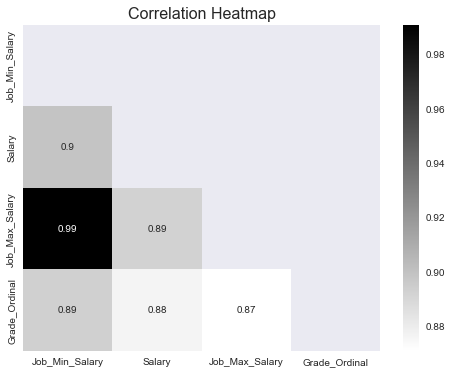

In [166]:
plt.figure(figsize = (8,6))
mask_ = np.zeros_like(correlation_matrix)
mask_[np.triu_indices_from(mask_)] = True
sns.heatmap(correlation_matrix, mask = mask_, annot=True, cmap = 'binary')
plt.title('Correlation Heatmap', size = 16)
plt.show()

The correlation between Salary, Job_Min_Salary, Job_Max_Salary and Grade_Ordinal features is categorized as Strong Correlation which means that these features are linearly positively correlated with each other.
Readers are expected not to be subjective when looking at the color comparison scale because when viewed the ratio is only in the range of 0.87 - 1.00.

#### - Significant Statistical

For further analytics, we should prove is there any significant statistical difference between Salary in each Job Employees title. With Kruskal-Wallis method for non-parametric (Salary) and more than one population (each Job Title).

In [167]:
# Kruskal-Wallis

stat, pvalue = kruskal(
    df[df['Job'] == 'Administration Assistant']['Salary'],
    df[df['Job'] == 'Marketing Manager']['Salary'],
    df[df['Job'] == 'Marketing Representative']['Salary'],
    df[df['Job'] == 'Purchasing Manager']['Salary'],
    df[df['Job'] == 'Purchasing Clerk']['Salary'],
    df[df['Job'] == 'Human Resources Representative']['Salary'],
    df[df['Job'] == 'Stock Manager']['Salary'],
    df[df['Job'] == 'Stock Clerk']['Salary'],
    df[df['Job'] == 'Shipping Clerk']['Salary'],
    df[df['Job'] == 'Programmer']['Salary'],
    df[df['Job'] == 'Public Relations Representative']['Salary'],
    df[df['Job'] == 'Sales Manager']['Salary'],
    df[df['Job'] == 'Sales Representative']['Salary'],
    df[df['Job'] == 'President']['Salary'],
    df[df['Job'] == 'Administration Vice President']['Salary'],
    df[df['Job'] == 'Finance Manager']['Salary'],
    df[df['Job'] == 'Accountant']['Salary'],
    df[df['Job'] == 'Accounting Manager']['Salary'],
    df[df['Job'] == 'Public Accountant']['Salary']
)

print('''
H0 : M1 = M2 = ... = Mk
Ha : at least one pair of the population are not equal (and we dont know which).
''')

if pvalue <= 0.05:
        print(f'pvalue = {pvalue:.10f}. Reject Ho. We assume at least one pair of the population Job Title are not equal (and we dont know which).')
else:
    print(f'pvalue = {pvalue:.10f}. Failed to reject Ho. We assume all population Job Title are significant.')


H0 : M1 = M2 = ... = Mk
Ha : at least one pair of the population are not equal (and we dont know which).

pvalue = 0.0000000000. Reject Ho. We assume at least one pair of the population Job Title are not equal (and we dont know which).


---

## **TOTAL EMPLOYEES**

### - Based on Job Title

In [168]:
df.groupby('Job').count()[['Name']].reset_index().rename(columns={'Name':'Total_Employees'}).sort_values('Total_Employees',ascending=False).head()

,Job,Total_Employees
15,Sales Representative,30
17,Stock Clerk,20
16,Shipping Clerk,20
0,Accountant,5
12,Purchasing Clerk,5


From the top 5 number of employees per Job Title in this company,

- *Sales Representative* takes first place. This company strategy focuses on Sales as the frontliner to be able to increase the company's sales level to get more profit by maximizing the number of Sales compared to others.

- However, from the top 5 title, the number of employees whose title is technician (*clerk*), the total number of employees exceeds that of Sales Representative. This indicates that how persistent the company is with the strategy to gain profit, the technical aspect of the company itself is more important. Stock Clerk, Shipping Clerk, and Purchasing Clerk are a work that is mutually continuous with each other. Especially for an import-export company for electronic equipment (according to the definition above) the technical determinant is an important factor for the running of the company.

In [169]:
df.groupby('Department').count()[['Name']].reset_index().rename(columns={'Name':'Total_Employees'}).sort_values('Total_Employees',ascending=False).head()

,Department,Total_Employees
10,Shipping,45
9,Sales,35
3,Finance,6
8,Purchasing,6
5,IT,5


My previous conclusion is supported by the table on the number of employees by department above. The frequency of the number of employees in the shipping department is more employed than sales, which means that the technical priority of the company must be prioritized before being able to market its products.

### - Country Based

Will be tested first to prove dependency statistically whether the Job feature is related to the Country feature (dependent) or not related (independent),

In [170]:
# Hypothesis
print('''
Ho : The two variables are independent
Ha : The two variables are dependent
''')

crosstab = pd.crosstab(df['Country'], df['Job'], margins=True)

stat, pvalue, dof, e = chi2_contingency(crosstab)

if pvalue <= 0.05:
    print(f'P-Value X2: {pvalue:.10f} \nReject Ho. \nBy  Chi-Squared Test for Independence, we assume Type Variable and Payment are not independent.') #saling bergantung
else: 
    print(f'P-Value X2: {pvalue:.10f} \nFailed to reject Ho. \nBy  Chi-Squared Test for Independence, we assume Type Variable and Payment are independent.')
print()


Ho : The two variables are independent
Ha : The two variables are dependent

P-Value X2: 0.0000000000 
Reject Ho. 
By  Chi-Squared Test for Independence, we assume Type Variable and Payment are not independent.



From the Chi Squared Statistical Hypothesis Test for dependencies between Job and Country features, it can be concluded that Job and Country are dependent.

This strengthens the assumption that Country Based determines the job and vice versa.
When investigated further,

In [171]:
df_total_per_country = df.groupby('Country').count()[['Name']].reset_index().rename(columns={'Name':'Total_Employees'}).sort_values('Total_Employees',ascending=False)
df_total_per_country

,Country,Total_Employees
3,United States of America,68
2,United Kingdom,36
0,Canada,2
1,Germany,1


In [172]:
# Bar Plot

fig = px.bar(df_total_per_country,
             x = 'Country', 
             y = 'Total_Employees',
             title = 'Number of Employees per Country Based')
fig.show()

In [173]:
df[df['Country']=='United States of America'][['Address','City']].value_counts()

Address              City               
2011 Interiors Blvd  South San Francisco    45
2004 Charade Rd      Seattle                18
2014 Jabberwocky Rd  Southlake               5
dtype: int64

In [174]:
df[df['Country']=='Germany']

,ID,Name,Department,Job,Address,City,Country,Region,Job_Min_Salary,Salary,Job_Max_Salary,Grade,Grade_Ordinal
60,204,Hermann Baer,Public Relations,Public Relations Representative,Schwanthalerstr. 7031,Munich,Germany,Europe,4500.0,10000.0,10500.0,D,2


From the information and visualization above, it can be concluded that
- The company's head office is located in USA, 2011 Interiors Blvd - South San Francisco.
- There is one employee who has a country based office in Germany with the title of a Public Relations Representative and is the only one in the company. The result that can be drawn from this unique spread is that he/she has good performance and even his salary is close to the upper limit of the maximum salary that can be earned in his position. *Hermann Baer* is a brilliant talent.

---

## **BUDGETING**

Further step for us to make *Salary* budgeting.

In [175]:
df_treemap = df.groupby(['Department','Job','Grade']).agg({'ID':'count','Salary':'sum'}).sort_values('Salary',ascending=False).reset_index().rename(columns={'ID':'Total_Employees','Salary':'Sum_Salary'})
df_treemap

,Department,Job,Grade,Total_Employees,Sum_Salary
0,Sales,Sales Representative,D,30,250500.0
1,Shipping,Shipping Clerk,E,20,64300.0
2,Sales,Sales Manager,C,5,61000.0
3,Shipping,Stock Clerk,E,20,55700.0
4,Finance,Accountant,D,5,39600.0
5,Shipping,Stock Manager,C,5,36400.0
6,Executive,Administration Vice President,B,2,34000.0
7,IT,Programmer,D,5,28800.0
8,Executive,President,A,1,24000.0
9,Purchasing,Purchasing Clerk,E,5,13900.0


In [176]:
fig = px.treemap(df_treemap,
                 path=['Department','Job'], 
                 values='Total_Employees', 
                 color = 'Sum_Salary',
                 color_continuous_scale='viridis',width=1000,height=700,
                 title = 'Total Salary Budgeting per Department'
                 )
fig.show()

The visualization above is only to describe the Salary budgeting for each Department and Job title of the company. Most of the company's salary budget is used for Sales.

---

## **SALARY**

### - Based on Department

This will be tested first to prove statistically whether there is any significance between each department based on salary.
With Kruskal-Wallis method for non-parametric (Salary) and more than one population (each Job Title).

In [177]:
# Kruskal-Wallis

stat, pvalue = kruskal(
    df[df['Department'] == 'Administration']['Salary'],
    df[df['Department'] == 'Marketing']['Salary'],
    df[df['Department'] == 'Purchasing']['Salary'],
    df[df['Department'] == 'Human Resources']['Salary'],
    df[df['Department'] == 'Shipping']['Salary'],
    df[df['Department'] == 'IT']['Salary'],
    df[df['Department'] == 'Public Relations']['Salary'],
    df[df['Department'] == 'Sales']['Salary'],
    df[df['Department'] == 'Executive']['Salary'],
    df[df['Department'] == 'Finance']['Salary'],
    df[df['Department'] == 'Accounting']['Salary']
)

print('''
H0 : M1 = M2 = ... = Mk
Ha : at least one pair of the population are not equal (and we dont know which).
''')

if pvalue <= 0.05:
        print(f'pvalue = {pvalue:.10f}. Reject Ho. We assume at least one pair of the population Department are not equal (and we dont know which).')
else:
    print(f'pvalue = {pvalue:.10f}. Failed to reject Ho. We assume all population Department are significant.')


H0 : M1 = M2 = ... = Mk
Ha : at least one pair of the population are not equal (and we dont know which).

pvalue = 0.0000000000. Reject Ho. We assume at least one pair of the population Department are not equal (and we dont know which).


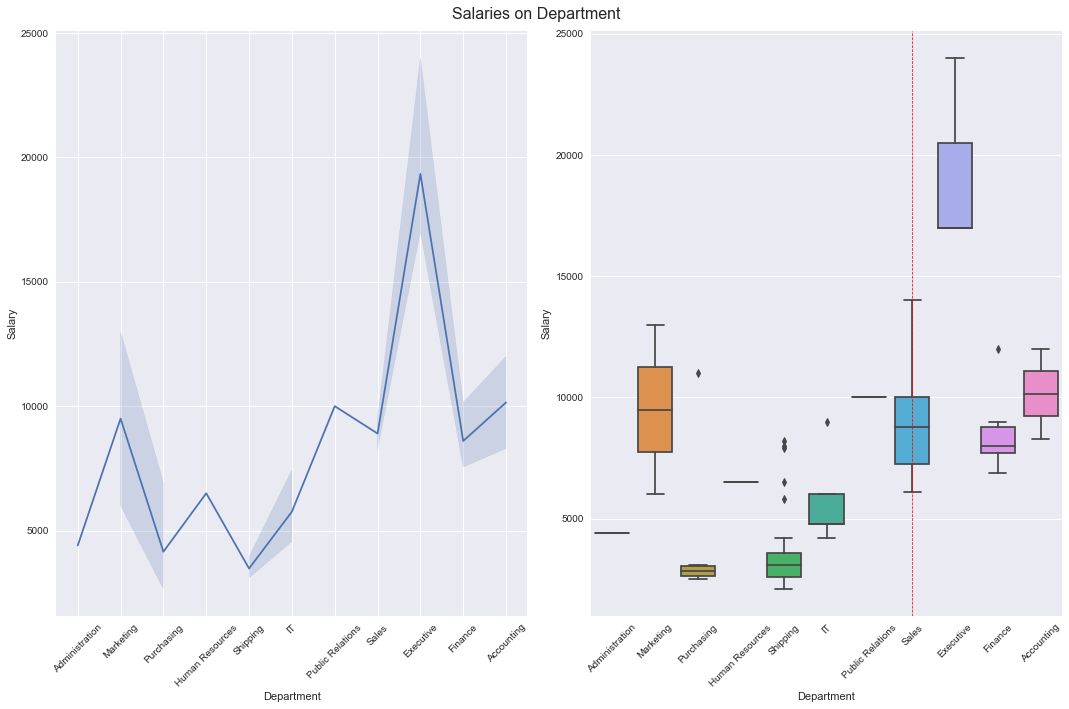

In [178]:
# Visualization

fig, axes = plt.subplots(1, 2, figsize=(15,10))
sns.lineplot(x = df['Department'], y = df['Salary'], ax=axes[0])
sns.boxplot(x=df['Department'], y=df['Salary'],ax=axes[1])
axes[0].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', rotation=45)
plt.axvline(7,linewidth=0.75 ,linestyle='--', color= 'red')
plt.suptitle('Salaries on Department', size=16)
fig.tight_layout()

It is interesting for us to discuss when we look at the vertical line in the Sales Department. The Sales Department has a longer range of salary data than other departments. 

For further analysis, we will take the Sales Department population which includes Sales Representatives and Sales Managers.

In [179]:
df_sales = df[df['Department']=='Sales']

From the range between Sales Representatives and Sales Managers, there is an overlapping salary, as below

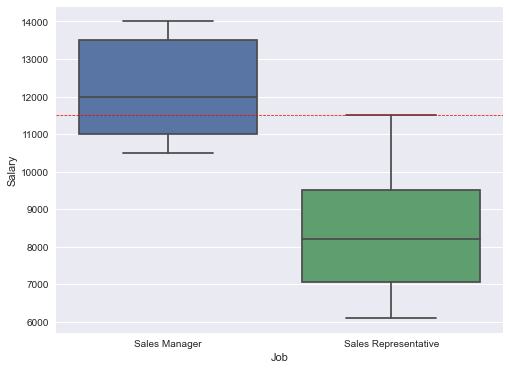

In [180]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df_sales['Job'],y=df_sales['Salary'])
plt.axhline(y=11500, linewidth= 0.75, linestyle= '--', color='red')
plt.show()

Subjectively, we can say that Sales Representative's Salary is lower under Sales Manager. However, in the visualization, there are several Sales Representatives whose salaries are greater than Sales Managers.

In [181]:
print(f'''
Range Salary Sales Department \t    : {df_sales['Salary'].min()} - {df_sales['Salary'].max()}.
----------------------------------------------------------

* Range Salary Sales Representative : {df_sales[df_sales['Grade']=='D']['Salary'].min()} - {df_sales[df_sales['Grade']=='D']['Salary'].max()}
* Range Salary Sales Manager \t    : {df_sales[df_sales['Grade']=='C']['Salary'].min()} - {df_sales[df_sales['Grade']=='C']['Salary'].max()}
''')


Range Salary Sales Department 	    : 6100.0 - 14000.0.
----------------------------------------------------------

* Range Salary Sales Representative : 6100.0 - 11500.0
* Range Salary Sales Manager 	    : 10500.0 - 14000.0



To see the overlapping Salaries, we will take the lower bound of Sales Manager Salary to the upper bound of Sales Representative Salary, as captured on below

In [182]:
df_sales_overlap = df_sales[(df_sales['Salary'] <= df_sales[df_sales['Grade']=='D']['Salary'].max()) & (df_sales['Salary'] >= df_sales[df_sales['Grade']=='C']['Salary'].min())]
df_sales_overlap

,ID,Name,Department,Job,Address,City,Country,Region,Job_Min_Salary,Salary,Job_Max_Salary,Grade,Grade_Ordinal
64,148,Gerald Cambrault,Sales,Sales Manager,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,10000.0,11000.0,20000.0,C,3
65,149,Eleni Zlotkey,Sales,Sales Manager,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,10000.0,10500.0,20000.0,C,3
78,162,Clara Vishney,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,10500.0,12000.0,D,2
84,168,Lisa Ozer,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,11500.0,12000.0,D,2
90,174,Ellen Abel,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,11000.0,12000.0,D,2


From the Sales Department, there are 5 employees whose salaries overlap between 3 Sales Representatives (Grade D) and 2 Sales Managers (Grade C).

Before we interpret and conclude the above findings further,
- first we will explore dependency t-test for two populations; Sales Representative Salary and Sales Manager Salary. Population Salary distributions approximately normal for each group

In [183]:
# 1.
# Var Check -----------------------------------------------------
print(f'''
Sales Representative Salary Variance : {round(df_sales[df_sales['Grade']=='D']['Salary'].var(),1)}
Sales Manager Salary Variance : {df_sales[df_sales['Grade']=='C']['Salary'].var()}
''')
# ---------------------------------------------------------------


Sales Representative Salary Variance : 2323275.9
Sales Manager Salary Variance : 2325000.0



In [184]:
# 2.
# By using T-Test Independent Double Population Mean Inequal Variance Method,

print(f'''
mu_1 : Sales Representative mean salary
mu_2 : Sales Manager mean salary

- H0: mu_1 = mu_2
- Ha: mu_1 != mu_2
''')

alpha = 0.05

tstat, pval = ttest_ind(df_sales[df_sales['Grade']=='D']['Salary'],df_sales[df_sales['Grade']=='C']['Salary'], equal_var = False)

if pval < alpha:
    print(f'Reject H0, {pval} < {alpha}')
else:
    print(f'Failed to reject H0, {pval} > {alpha}')


mu_1 : Sales Representative mean salary
mu_2 : Sales Manager mean salary

- H0: mu_1 = mu_2
- Ha: mu_1 != mu_2

Reject H0, 0.002665039932809353 < 0.05


From the comparison double independent t-test of mean 2 populations above with inequal variances method and using a 95% confidence level ($alpha = 0.5$),
$$pvalue < alpha$$
This reinforces our assumption that the mean salary between sales representatives and sales managers are not the same.

However, in the visualization there are Sales Representative Staff whose salary exceeds that of the Sales Manager. In general, this violates the rules and standards of salary assessment based on grade.

In general, the base salary of a sales staff is not much different from the salary of staff in other departments. However, based on the case above, the real evidence of the salary that a sales gets will depend on his performance, how well a salesperson offers and sells his products in the form of *Incentives*. Thus, we can assume that the Variable Salary is not only the basic salary earned, but bonuses and incentives received by each employee.

### - Based on Job Title

To strengthen the assumptions and statements that we have previously stated, we will raise another issue based on other job titles.

In [185]:
df[df['Job']=='Stock Manager']

,ID,Name,Department,Job,Address,City,Country,Region,Job_Min_Salary,Salary,Job_Max_Salary,Grade,Grade_Ordinal
10,120,Matthew Weiss,Shipping,Stock Manager,2011 Interiors Blvd,South San Francisco,United States of America,Americas,5500.0,8000.0,8500.0,C,3
11,121,Adam Fripp,Shipping,Stock Manager,2011 Interiors Blvd,South San Francisco,United States of America,Americas,5500.0,8200.0,8500.0,C,3
12,122,Payam Kaufling,Shipping,Stock Manager,2011 Interiors Blvd,South San Francisco,United States of America,Americas,5500.0,7900.0,8500.0,C,3
13,123,Shanta Vollman,Shipping,Stock Manager,2011 Interiors Blvd,South San Francisco,United States of America,Americas,5500.0,6500.0,8500.0,C,3
14,124,Kevin Mourgos,Shipping,Stock Manager,2011 Interiors Blvd,South San Francisco,United States of America,Americas,5500.0,5800.0,8500.0,C,3


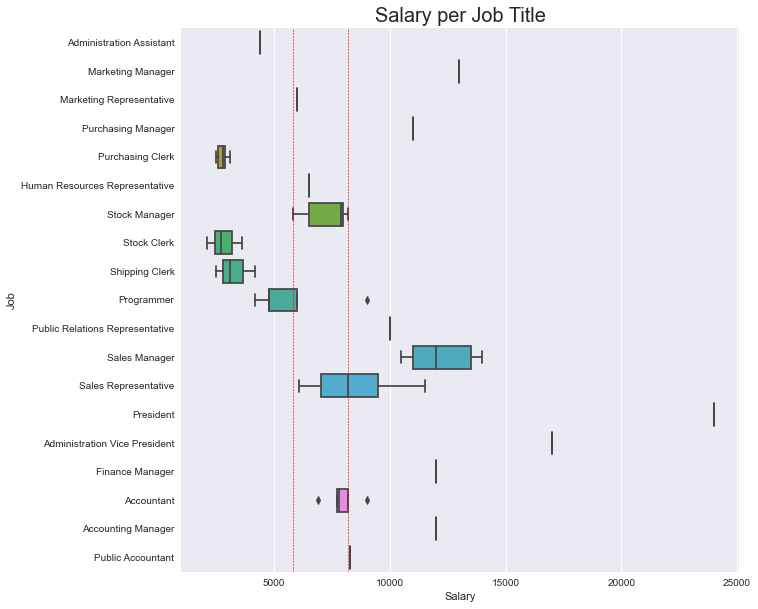

In [186]:
plt.figure(figsize=(10,10))
sns.boxplot(x=df['Salary'],y=df['Job'])
plt.axvline(x=df[df['Job']=='Stock Manager']['Salary'].max(), linestyle = 'dashed', color='red', linewidth=0.6)
plt.axvline(x=df[df['Job']=='Stock Manager']['Salary'].min(), linestyle = 'dashed', color='red', linewidth=0.6)
plt.title('Salary per Job Title', size=20)
plt.show()

In [187]:
print('Max Salary from Stock Manager : ',df[df['Job']=='Stock Manager']['Salary'].max())
print('Mean Salary of Sales Representative : ',df[df['Job']=='Sales Representative']['Salary'].mean())

Max Salary from Stock Manager :  8200.0
Mean Salary of Sales Representative :  8350.0


Reinforcing our previous statement regarding incentives received by Sales, it can be seen in the boxplot above that some Sales Representatives have higher Salaries than Stock Managers even the maximum salary of Stock Manager is lower than the average Salary of Sales Representative.

The job description of the Stock Manager oversees is to track and monitor inventory and develop processes to maximize efficiency. If compared with the job description of a Sales as a frontliner who directly affects the company's profit to market their products, the complexity of the job description in this case affects the salary received more.

We can conclude that the complexity of the work affects the salary. It will be a more valid development if HR data has parameter feature for the complexity of the Job Description of each employee.

### - Sales Representative Performance

Departing from whole statements that we have conclude above, how well a Sales performs can be seen from the Salary he/she gets.

In [188]:
df_SalesR = df[df['Job']=='Sales Representative']

Assuming the `basic salary of each Sales Representative is the same` i.e. the minimum salary ($6000) and `the portion of workload between Sales is the same`, we will add a new variable, namely `Incentive` as a feature to inform the incentive bonus he/she receives outside the basic salary.

In [189]:
df_SalesR['Incentive'] = df['Salary'] - df['Job_Min_Salary']

How well the Sales Representative performs will be presented based on the average incentive of all Sales Representatives as a boundary.

In [190]:
df_SalesR.head()

,ID,Name,Department,Job,Address,City,Country,Region,Job_Min_Salary,Salary,Job_Max_Salary,Grade,Grade_Ordinal,Incentive
66,150,Peter Tucker,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,10000.0,12000.0,D,2,4000.0
67,151,David Bernstein,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,9500.0,12000.0,D,2,3500.0
68,152,Peter Hall,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,9000.0,12000.0,D,2,3000.0
69,153,Christopher Olsen,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,8000.0,12000.0,D,2,2000.0
70,154,Nanette Cambrault,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,7500.0,12000.0,D,2,1500.0


- Sales Representative with Good Performance,

In [191]:
df_sales_Good = df_SalesR[df_SalesR['Incentive']>=df_SalesR['Incentive'].mean()]
df_sales_Good

,ID,Name,Department,Job,Address,City,Country,Region,Job_Min_Salary,Salary,Job_Max_Salary,Grade,Grade_Ordinal,Incentive
66,150,Peter Tucker,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,10000.0,12000.0,D,2,4000.0
67,151,David Bernstein,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,9500.0,12000.0,D,2,3500.0
68,152,Peter Hall,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,9000.0,12000.0,D,2,3000.0
72,156,Janette King,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,10000.0,12000.0,D,2,4000.0
73,157,Patrick Sully,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,9500.0,12000.0,D,2,3500.0
74,158,Allan McEwen,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,9000.0,12000.0,D,2,3000.0
78,162,Clara Vishney,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,10500.0,12000.0,D,2,4500.0
79,163,Danielle Greene,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,9500.0,12000.0,D,2,3500.0
84,168,Lisa Ozer,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,11500.0,12000.0,D,2,5500.0
85,169,Harrison Bloom,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,10000.0,12000.0,D,2,4000.0


In [192]:
print('Sales Representative with Good Performance :\n', df_sales_Good['Name'].unique())

Sales Representative with Good Performance :
 ['Peter Tucker' 'David Bernstein' 'Peter Hall' 'Janette King'
 'Patrick Sully' 'Allan McEwen' 'Clara Vishney' 'Danielle Greene'
 'Lisa Ozer' 'Harrison Bloom' 'Tayler Fox' 'Ellen Abel' 'Alyssa Hutton'
 'Jonathon Taylor' 'Jack Livingston']


- Sales Representative with Under Performance,

In [193]:
df_sales_Under = df_SalesR[df_SalesR['Incentive']<df_SalesR['Incentive'].mean()]
df_sales_Under

,ID,Name,Department,Job,Address,City,Country,Region,Job_Min_Salary,Salary,Job_Max_Salary,Grade,Grade_Ordinal,Incentive
69,153,Christopher Olsen,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,8000.0,12000.0,D,2,2000.0
70,154,Nanette Cambrault,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,7500.0,12000.0,D,2,1500.0
71,155,Oliver Tuvault,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,7000.0,12000.0,D,2,1000.0
75,159,Lindsey Smith,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,8000.0,12000.0,D,2,2000.0
76,160,Louise Doran,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,7500.0,12000.0,D,2,1500.0
77,161,Sarath Sewall,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,7000.0,12000.0,D,2,1000.0
80,164,Mattea Marvins,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,7200.0,12000.0,D,2,1200.0
81,165,David Lee,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,6800.0,12000.0,D,2,800.0
82,166,Sundar Ande,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,6400.0,12000.0,D,2,400.0
83,167,Amit Banda,Sales,Sales Representative,"""Magdalen Centre",OX9 9ZB,United Kingdom,Europe,6000.0,6200.0,12000.0,D,2,200.0


In [194]:
print('Sales Representative with Under Performance :\n', df_sales_Under['Name'].unique())

Sales Representative with Under Performance :
 ['Christopher Olsen' 'Nanette Cambrault' 'Oliver Tuvault' 'Lindsey Smith'
 'Louise Doran' 'Sarath Sewall' 'Mattea Marvins' 'David Lee' 'Sundar Ande'
 'Amit Banda' 'William Smith' 'Elizabeth Bates' 'Sundita Kumar'
 'Kimberely Grant' 'Charles Johnson']


- Sales Representative Performances

In [195]:
df_sales_Good['Performance'] = 'Good'
df_sales_Under['Performance'] = 'Under'

df_performance = pd.concat([df_sales_Under,df_sales_Good])
df_performance[['ID','Name','Performance']]

,ID,Name,Performance
69,153,Christopher Olsen,Under
70,154,Nanette Cambrault,Under
71,155,Oliver Tuvault,Under
75,159,Lindsey Smith,Under
76,160,Louise Doran,Under
77,161,Sarath Sewall,Under
80,164,Mattea Marvins,Under
81,165,David Lee,Under
82,166,Sundar Ande,Under
83,167,Amit Banda,Under


---

## `=================================` **`CONCLUSION`** `=================================`

Solutions and steps that should be taken by the company from the problems and the given HR Database that have been discussed previously:

1. Recommendations for making salary structure based on *Competency Based* (similar to fit and proper test). Employees who have good performance will be promoted. Promotion is not directly based on Grade (ex. from D to C), but must go through a career ladder based on Grade_Class (from Junior to Middle, then Middle to Senior). When Grade_Class is in the upper class (senior), employees can take competency based to Grade promotion.

    Adding the Grade_Class feature is the most optimal solution for this point.

**Grade_Class** : derived from the Salary per Job Title to describe Class of Grade.
-    **Junior** : below median Salary per Job Title
-    **Middle** : median Salary per Job Title
-    **Senior** : over median Salary per Job Title

In [196]:
# Grade_Class
df['Grade_Class'] = grade_class('Job')
df

,ID,Name,Department,Job,Address,City,Country,Region,Job_Min_Salary,Salary,Job_Max_Salary,Grade,Grade_Ordinal,Grade_Class
0,200,Jennifer Whalen,Administration,Administration Assistant,2004 Charade Rd,Seattle,United States of America,Americas,3000.0,4400.0,6000.0,D,2,Middle
1,201,Michael Hartstein,Marketing,Marketing Manager,147 Spadina Ave,Toronto,Canada,Americas,9000.0,13000.0,15000.0,C,3,Middle
2,202,Pat Fay,Marketing,Marketing Representative,147 Spadina Ave,Toronto,Canada,Americas,4000.0,6000.0,9000.0,D,2,Middle
3,114,Den Raphaely,Purchasing,Purchasing Manager,2004 Charade Rd,Seattle,United States of America,Americas,8000.0,11000.0,15000.0,C,3,Middle
4,115,Alexander Khoo,Purchasing,Purchasing Clerk,2004 Charade Rd,Seattle,United States of America,Americas,2500.0,3100.0,5500.0,E,1,Senior
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,111,Ismael Sciarra,Finance,Accountant,2004 Charade Rd,Seattle,United States of America,Americas,4200.0,7700.0,9000.0,D,2,Junior
103,112,Jose Manuel Urman,Finance,Accountant,2004 Charade Rd,Seattle,United States of America,Americas,4200.0,7800.0,9000.0,D,2,Middle
104,113,Luis Popp,Finance,Accountant,2004 Charade Rd,Seattle,United States of America,Americas,4200.0,6900.0,9000.0,D,2,Junior
105,205,Shelley Higgins,Accounting,Accounting Manager,2004 Charade Rd,Seattle,United States of America,Americas,8200.0,12000.0,16000.0,C,3,Middle


2. Implement a reward and punishment system for each employee. For employees whose performance is good, they will get rewards that can be in the form of an increase in Grade Class or the provision of incentives on the salary they get in order to spur employees to continue to give their best performance for the company's profit and the company can retain its best employees. Meanwhile, employees who underperform will receive punishment, from the lightest, namely persuasive counseling for underperforming employees, giving drying letters and even demotion. This also refers to employees being able to give their best performance so they don't get punishment for the company's profit.

## `=============================================================================`

---

## **EXPORT DATABASE TO EXCEL**

In [197]:
df.to_excel('Capstone Project 2 - Giovano Aditya Graha.xlsx', sheet_name='HR Database', index=False)

---

## **STUDY CASE DEVELOPMENT** 

1. Forecasting salaries for the next period from the database, with the addition of features and other parameters.
2. Performance assessment is based on a study of the data that has been developed.
3. Selection of competent new employees based on the database.

---

$$(:  THANK YOU  :)$$

---
---